# Personalized Medicine: Redefining Cancer Treatment Project

**Predict the effect of Genetic Variants to enable Personalized Medicine**

*Author: Eda AYDIN*

## Business Understanding

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt tthe way diseases are treated. 

But this is only partially due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from neutral mutations (passengers)

Currently this interpretation of genetic mutations is being done manually. This is a very-time consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a machine learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition on Kaggle. This was launched by Memorial Sloan Kettering Cancer Center (MSKCC)

## Data Understanding

There are nine different classes a genetic mutation can be classified on.

This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical for the success of your approach.

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

Finally, to make it more exciting!! Some of the test data is machine-generated to prevent hand labeling. You will submit all the results of your classification algorithm, and we will ignore the machine-generated samples. 

## File Descriptions

* training_variants - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the amino acid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)
* training_text - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
* test_variants - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the amino acid change for this mutations)
* test_text - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
* submissionSample - a sample submission file in the correct format

## Import library and data

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
from scipy.sparse import hstack

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Machine Learning
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from mlxtend.classifier import StackingClassifier

# NLP
from nltk.corpus import stopwords

# Other libraries
import re
import time
import math

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from collections import Counter, defaultdict

In [2]:
# Loading training_variants and training_text
data_variants = pd.read_csv("training_variants")
data_text = pd.read_csv("training_text", sep = "\|\|", engine= "python",
                        names= ["ID","TEXT"], skiprows = 1)

In [3]:
data_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


**There are 4 fields above:**

1. ID: row id used to linke the mutation to the clinical evidence
2. Gene: the gene where the genetic mutation is located
3. Variation: the amino acid change for this mutations
4. Class: class value 1-9, this genetic has been classified on 

In [4]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


The above dataset have 2 columns which are ID and Text column.We can also observe column Id which is common in both dataset. Let's exploring it.

## Analyzing Data

### Training Variants

In [5]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [6]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [7]:
data_variants.shape

(3321, 4)

### Training Text

In [8]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [9]:
data_text.shape

(3321, 2)

Summary: 

In short our datasets look like this
* data_variants( ID, Gene, Variations, Class)
* data_text (ID,text)

Now, we understood the dataset. Let's try to understand the same problem from Machine Learning point of view.

We want to predict about class of cancer. Now question is what kind of data is present in class column.

In [10]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Ths is discrete data so it's classification problem and since there are multiple discrete output possible so we can call it Multi-class classification problem.

**Important Note**: This is medical related problem so correct results are very important. Error can be really costly here so we will have to have result for each class in terms of probability. We might not be much bothered about time taken by ML algorithm as far as it is reasonable.

We also want our model to be highly interpretable because a medical practitioner want to also give proper reasoning on why ML algorithm is predicting any class.

We will evaluate our model using confusion matrix and multi-class log-loss.

So no, we understand the problem statement.

## Preprocessing Data

In [11]:
import nltk
nltk.download("stopwords")

# Remove all stop words like a, is, an, the, etc.
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to C:\Users\Eda
[nltk_data]     AYDIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def data_text_preprocess(total_text, index, column):
    # Remove int values from text data as that might not be important
    if type(total_text) is not int:
        string = ""
        
        # replace all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        
        # replace multiple spaces with single space
        total_text = re.sub('\s+', ' ', str(total_text))
        
        # bring whole text to same lower-case scale
        total_text = total_text.lower()
        
        for word in total_text.split():
            # if the word is not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [13]:
for index, row in data_text.iterrows():
    if type(row["TEXT"]) is str:
        data_text_preprocess(row["TEXT"], index, "TEXT")

## Removing Missing Data

In [14]:
# merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text, on = "ID", how= "left")
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [15]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see that many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it. Let's go with imputation.

But the question is what to impute here?

In [16]:
# Try to merge Gene and variation column
result.loc[result["TEXT"].isnull(), "TEXT"] = result["Gene"] +' '+ result["Variation"]

In [17]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


## Creating training, test, and validation data

Before we split the data into training, test, and validation dataset. We want to ensure that all spaces in Gene and Variation column to be replaced by ...

In [18]:
y_true = result["Class"].values
result.Gene = result.Gene.str.replace("\s+", "_")
result.Variation = result.Variation.str.replace("\s+", "_")

In [19]:
# Split the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# Split the train data now into train validation and cross validation
train_df, val_df, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [20]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', val_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [21]:
train_class_distribution = train_df["Class"].value_counts().sort_index()
test_class_distribution = test_df["Class"].value_counts().sort_index()
val_class_distribution = val_df["Class"].value_counts().sort_index()

In [22]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

So, what does above variable suggest us.

This means in our train dataset we have class 1 values with count of 363, class 2 values having count 289 and so on.

It will be better idea to visualize it in graph format.

## Visualizing Data

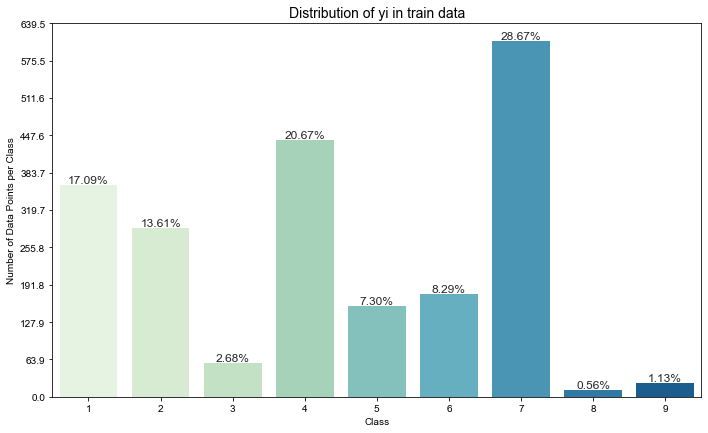

In [23]:
ncount = len(train_df)

### HISTOGRAM ACCORDING TO ICU
ax = sns.countplot(train_df['Class'], palette='GnBu')
sns.set(font_scale = 1)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Data Points per Class")
fig = plt.gcf()
fig.set_size_inches(10,6)

for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y),ha='center', va='bottom')  # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.tight_layout()
plt.title('Distribution of yi in train data', fontsize=14)
plt.show()

In [24]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


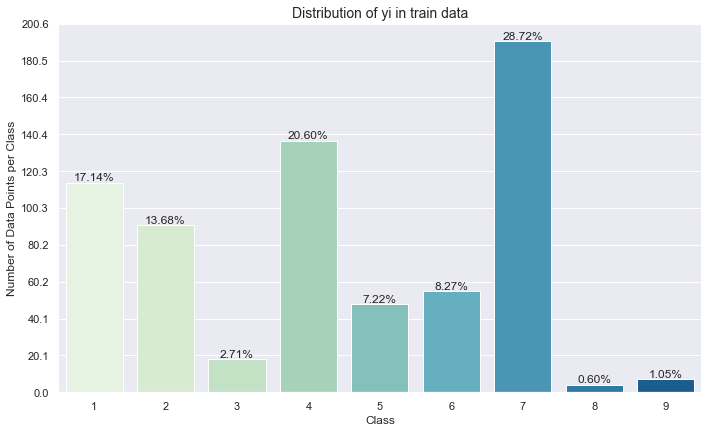

In [25]:
ncount = len(test_df)

### HISTOGRAM ACCORDING TO ICU
ax = sns.countplot(test_df['Class'], palette='GnBu')
sns.set(font_scale = 1)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Data Points per Class")
fig = plt.gcf()
fig.set_size_inches(10,6)

for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y),ha='center', va='bottom')  # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.tight_layout()
plt.title('Distribution of yi in train data', fontsize=14)
plt.show()

In [26]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


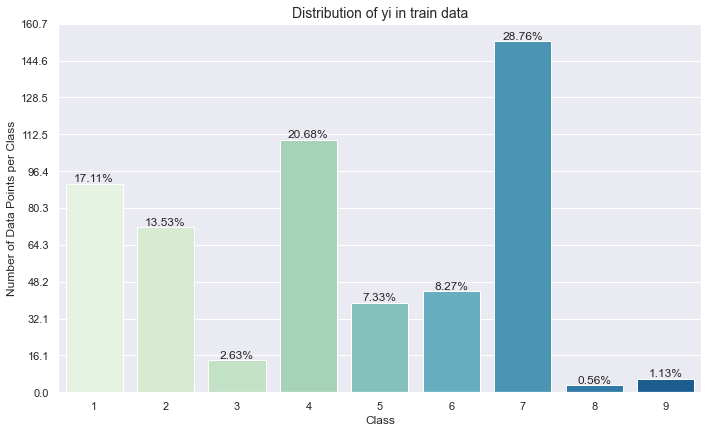

In [27]:
ncount = len(val_df)

### HISTOGRAM ACCORDING TO ICU
ax = sns.countplot(val_df['Class'], palette='GnBu')
sns.set(font_scale = 1)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Data Points per Class")
fig = plt.gcf()
fig.set_size_inches(10,6)

for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y),ha='center', va='bottom')  # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.tight_layout()
plt.title('Distribution of yi in train data', fontsize=14)
plt.show()

In [28]:
sorted_yi = np.argsort(-val_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',val_class_distribution.values[i], '(', np.round((val_class_distribution.values[i]/val_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Now the question is because we need log-loss as final evaluation metrics how do we say that model we are going build will be a good model. For doing this we will build a random model and evaluate log loss. Our model should return lower log loss value than this.

## Building a random model

We need to generate 9 random numbers because we have 9 classes such that their sum is equal to 1 because the sum of probability is equal to 1.

In [29]:
test_data_len = test_df.shape[0]
val_data_len = val_df.shape[0]

In [30]:
# we create a output array that has exactly same size as the CV data
val_predicted_y = np.zeros((val_data_len, 9))
for i in range(val_data_len):
    rand_probs = np.random.rand(1,9)
    val_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_val, val_predicted_y, eps= 1e-15))

Log loss on Cross Validation Data using Random Model 2.425448726150638


In [31]:
# Test Error
# We create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.474954970997216


In [32]:
# Let's get the index of max probability
predicted_y = np.argmax(test_predicted_y, axis=1)

In [33]:
# Let's see the output
predicted_y

array([4, 0, 8, 8, 0, 5, 5, 5, 0, 8, 7, 8, 6, 3, 8, 5, 1, 3, 6, 4, 6, 1,
       1, 8, 2, 1, 7, 5, 4, 2, 5, 7, 4, 0, 8, 8, 0, 0, 1, 1, 0, 0, 0, 5,
       7, 6, 1, 5, 1, 0, 2, 2, 1, 7, 5, 8, 0, 1, 7, 1, 3, 1, 8, 8, 7, 5,
       5, 4, 5, 4, 0, 7, 3, 8, 1, 7, 0, 1, 0, 0, 1, 8, 3, 8, 8, 0, 2, 6,
       7, 1, 5, 0, 4, 2, 4, 2, 4, 5, 7, 7, 3, 7, 0, 4, 6, 6, 1, 1, 1, 7,
       5, 8, 1, 2, 7, 2, 8, 8, 6, 8, 0, 0, 8, 7, 2, 0, 1, 1, 5, 3, 2, 1,
       0, 7, 1, 3, 5, 4, 8, 6, 8, 3, 6, 2, 7, 6, 8, 6, 4, 7, 7, 7, 2, 7,
       1, 8, 0, 6, 4, 3, 1, 6, 3, 4, 3, 2, 8, 1, 1, 8, 2, 7, 7, 4, 6, 8,
       5, 5, 0, 6, 7, 1, 7, 4, 8, 0, 7, 7, 6, 0, 5, 2, 6, 7, 4, 7, 2, 8,
       2, 0, 1, 2, 0, 7, 3, 6, 5, 7, 1, 1, 3, 8, 3, 6, 5, 6, 0, 6, 4, 4,
       7, 5, 3, 1, 7, 7, 1, 3, 3, 3, 0, 2, 2, 3, 3, 7, 1, 3, 8, 0, 7, 7,
       1, 0, 1, 7, 1, 4, 2, 8, 0, 4, 8, 0, 7, 7, 7, 5, 1, 0, 5, 3, 1, 7,
       7, 8, 2, 3, 2, 5, 2, 4, 7, 7, 1, 5, 4, 0, 8, 0, 2, 6, 2, 2, 1, 6,
       2, 7, 3, 0, 7, 3, 6, 3, 5, 4, 3, 7, 2, 1, 8,

So you can see the index value ranging from 0 to 8. Let's make it as 1 to 9 we will increase this value by 1.

In [34]:
predicted_y = predicted_y + 1
predicted_y

array([5, 1, 9, 9, 1, 6, 6, 6, 1, 9, 8, 9, 7, 4, 9, 6, 2, 4, 7, 5, 7, 2,
       2, 9, 3, 2, 8, 6, 5, 3, 6, 8, 5, 1, 9, 9, 1, 1, 2, 2, 1, 1, 1, 6,
       8, 7, 2, 6, 2, 1, 3, 3, 2, 8, 6, 9, 1, 2, 8, 2, 4, 2, 9, 9, 8, 6,
       6, 5, 6, 5, 1, 8, 4, 9, 2, 8, 1, 2, 1, 1, 2, 9, 4, 9, 9, 1, 3, 7,
       8, 2, 6, 1, 5, 3, 5, 3, 5, 6, 8, 8, 4, 8, 1, 5, 7, 7, 2, 2, 2, 8,
       6, 9, 2, 3, 8, 3, 9, 9, 7, 9, 1, 1, 9, 8, 3, 1, 2, 2, 6, 4, 3, 2,
       1, 8, 2, 4, 6, 5, 9, 7, 9, 4, 7, 3, 8, 7, 9, 7, 5, 8, 8, 8, 3, 8,
       2, 9, 1, 7, 5, 4, 2, 7, 4, 5, 4, 3, 9, 2, 2, 9, 3, 8, 8, 5, 7, 9,
       6, 6, 1, 7, 8, 2, 8, 5, 9, 1, 8, 8, 7, 1, 6, 3, 7, 8, 5, 8, 3, 9,
       3, 1, 2, 3, 1, 8, 4, 7, 6, 8, 2, 2, 4, 9, 4, 7, 6, 7, 1, 7, 5, 5,
       8, 6, 4, 2, 8, 8, 2, 4, 4, 4, 1, 3, 3, 4, 4, 8, 2, 4, 9, 1, 8, 8,
       2, 1, 2, 8, 2, 5, 3, 9, 1, 5, 9, 1, 8, 8, 8, 6, 2, 1, 6, 4, 2, 8,
       8, 9, 3, 4, 3, 6, 3, 5, 8, 8, 2, 6, 5, 1, 9, 1, 3, 7, 3, 3, 2, 7,
       3, 8, 4, 1, 8, 4, 7, 4, 6, 5, 4, 8, 3, 2, 9,

## Confusion, Precision, and Recall Matrix 

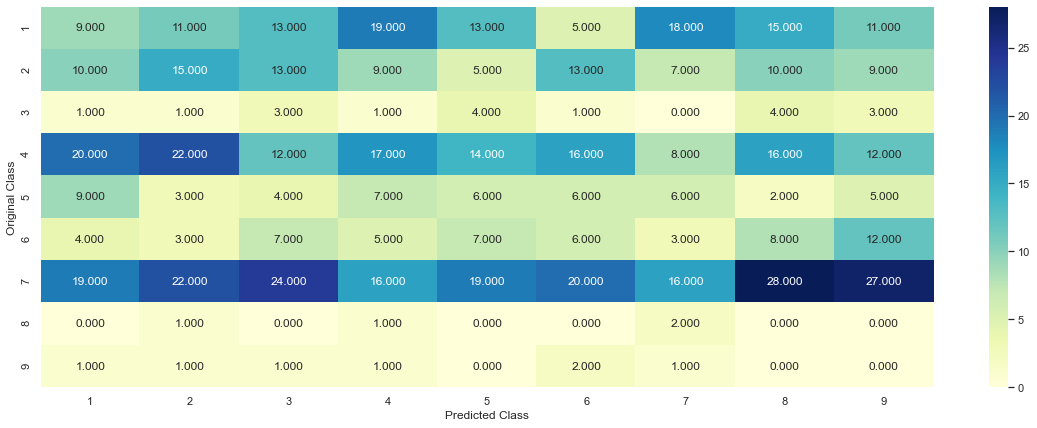

In [35]:
# Confusion Matrix
C = confusion_matrix(y_test, predicted_y)

labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

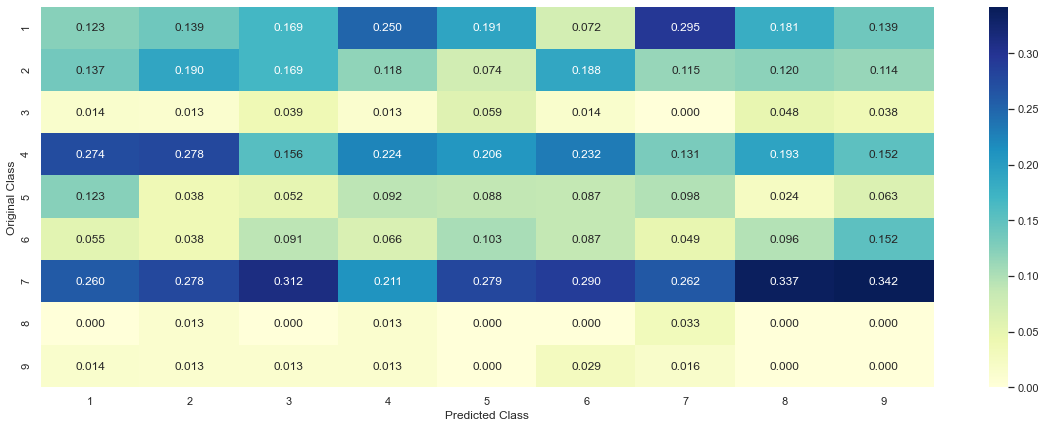

In [36]:
# Precision Matrix
B =(C/C.sum(axis=0))

plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

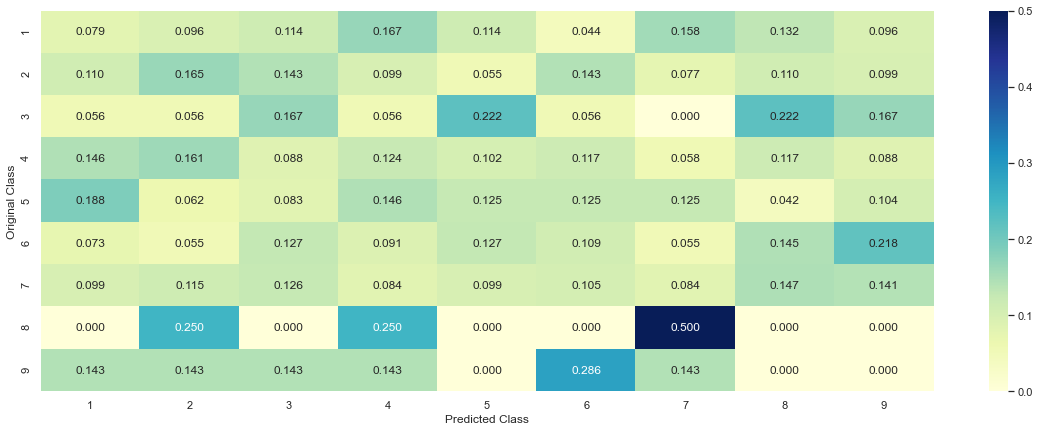

In [37]:
# Recall Matrix
A =(((C.T)/(C.sum(axis=1))).T)

plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## One-hot Encoding

Now we will look at teach independent columns to make sure its relevant for our target variable bu the question is, how? Let's understand with our first column Gene which is categorical in nature.

Let's explore column Gene and look at its distribution.

In [38]:
unique_genes = train_df["Gene"].value_counts()
print("Number of Unique Genes : {}".format(unique_genes.shape[0]))
unique_genes.head(10)

Number of Unique Genes : 237


BRCA1     160
TP53      108
EGFR       92
BRCA2      78
PTEN       76
KIT        61
BRAF       54
ERBB2      43
ALK        42
PDGFRA     39
Name: Gene, dtype: int64

In [39]:
# Let's see the number of unique values present in gene
unique_genes.shape[0]

237

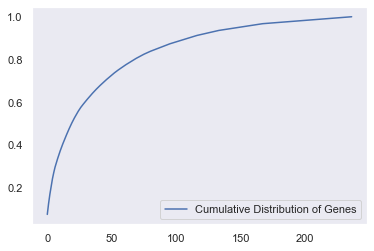

In [40]:
# Let's look at the cumulative distribution of unique Genese values

s = sum(unique_genes.values)
h = unique_genes.values / s
c = np.cumsum(h)

plt.plot(c, label = "Cumulative Distribution of Genes")
plt.grid()
plt.legend()
plt.show()

So we need to convert these categorical variable to appropriate format which or machine learning will be able to take as a input. We will have 2 techniques to deal with

* One-hot Encoding
* Response Encoding (Mea Imputation)

We will use both of them to see which one work best. Now we will start encoding using the one-hot encoder.

In [41]:
# One-hot encoding of Gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df["Gene"])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df["Gene"])
val_gene_feature_onehotCoding = gene_vectorizer.transform(val_df["Gene"])

In [42]:
# Let's check the number of column generated after one-hot encoding
train_gene_feature_onehotCoding.shape


(2124, 236)

In [43]:
# column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()
 

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',


## Response Encoding

In [44]:
"""
Summary: Code for response coding with Laplace smoothing
Args:
    alpha ([integer]): used for Laplace smoothing
    feature ([list]): ["Gene", "Variation"]
    df ([dataframe]): ["traind_df", "test_df", "val_df"]

Algorithm

Consider all unique values and the number of occurances of given feature in train data dataframe build a vector  (1*19), the first element = (number of times its occurred in class1 + 10*alpha / number of time it occurred in total data + 90*alpha)

gv_dict is like a look up table for every gene its store a (1*9) representation of it for a value of feature in df:
    if it is in train data:
        we add the vector that was stored in "gv_dict" look up table to "gv_fea"
    if it is not there in train data:
        we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
return "gv_fea"
"""

# get_gv_fea_dict = Get Gene Variation Feature Dict

def get_gv_fea_dict(alpha, feature, df):
    """
    Args:
        value_count: it contains a dict like
    
        print(train_df['Gene'].value_counts())
        output:
            {
                BRCA1     173
                TP53      114
                EGFR       86
                PTEN       80
                BRCA2      72
                        ... 
                LATS1       1
                SDHB        1
                CDKN2B      1
                ARAF        1
                AXL         1
            }
        print(train_df['Variation'].value_counts())
        output:
            {
                Truncating_Mutations    60
                Deletion                47
                Amplification           42
                Fusions                 25
                G12V                     4
                                        ..
                F384Y                    1
                S1986F                   1
                F1524V                   1
                T19N                     1
                P34R                     1
            }   
    """
    
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene / variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occurred in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi == 1 / Gi)) probability of gene, variation belongs to particular class
        
        #vec is 9 dimensional vector
        vec = []
        
        for k in range(1,10):
            """
                print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
                Output: 
                {
                    ID   Gene             Variation  Class  \
                    2421  2421  BRCA1  Truncating_Mutations      1   
                    2583  2583  BRCA1                E1660G      1   
                    2579  2579  BRCA1                G1763V      1   
                    2510  2510  BRCA1                S1841N      1   
                    2592  2592  BRCA1                V1838E      1   
                    2577  2577  BRCA1                A1752V      1   
                    2619  2619  BRCA1                V1810G      1   
                    2438  2438  BRCA1                W1837C      1   
                    2596  2596  BRCA1                G1788D      1   
                    2586  2586  BRCA1                M1628V      1   
                    2432  2432  BRCA1                L1657P      1   
                }
            """
            
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occurred in whole data
            
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
            
        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each value in the data
    gv_fea = []
    
    # for every feature values in the given data frame we will check if it is in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index,row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [45]:
# response-coding of the Gene feature

# alpha is used for Laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

# val gene feature
val_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", val_df))

In [46]:
# Let's look at columns after applying response encoding. We must have 9 columns for Gene colmun after response encoding.
train_gene_feature_responseCoding.shape

(2124, 9)

The question is how good is Gene column feature to predict 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic Regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important. 

In [47]:
# We need a hyperparamaeter for SGD Classifier
alpha = [10 ** x for x in range(-5,1)]

In [48]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result in probability format to be used for log loss

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(val_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.1959569303965198
For values of alpha =  0.0001 The log loss is: 1.1754501441458598
For values of alpha =  0.001 The log loss is: 1.2105216395062968
For values of alpha =  0.01 The log loss is: 1.3230029352890162
For values of alpha =  0.1 The log loss is: 1.4021974723552608
For values of alpha =  1 The log loss is: 1.4360579968750586


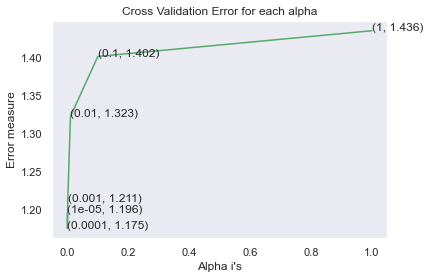

In [49]:
# Let's plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [50]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9864349324129628
For values of best alpha =  0.0001 The cross validation log loss is: 1.1754501441458598
For values of best alpha =  0.0001 The test log loss is: 1.1955310923704698


In [53]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
val_coverage=val_df[val_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [54]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',val_coverage, 'out of ',val_df.shape[0],":" ,(val_coverage/val_df.shape[0])*100)

1. In test data 647 out of 665 : 97.29323308270676
2. In cross validation data 517 out of  532 : 97.18045112781954


## Evaluation Variation Column

Variation is also a categorical variable so we have to deal in same way like we have done for Gene column. We will again get the one-hot encoder and response encoding variable for variation column.

In [55]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occurred most
print(unique_variations.head(10))

Number of Unique Variations : 1929
Truncating_Mutations    62
Deletion                50
Amplification           46
Fusions                 20
Overexpression           4
E17K                     3
M1R                      2
F384L                    2
R170W                    2
P34R                     2
Name: Variation, dtype: int64


[0.02919021 0.0527307  0.07438795 ... 0.99905838 0.99952919 1.        ]


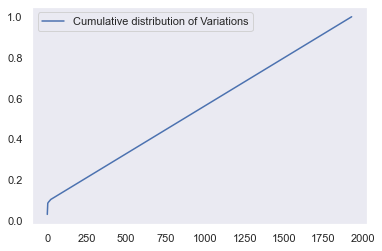

In [56]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [57]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
val_variation_feature_onehotCoding = variation_vectorizer.transform(val_df['Variation'])

In [58]:
train_variation_feature_onehotCoding.shape

(2124, 1961)

In [59]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
val_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", val_df))

In [60]:
train_variation_feature_responseCoding.shape

(2124, 9)

In [61]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [63]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(val_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7094646989778417
For values of alpha =  0.0001 The log loss is: 1.708434691630544
For values of alpha =  0.001 The log loss is: 1.7087565021444153
For values of alpha =  0.01 The log loss is: 1.715833371715003
For values of alpha =  0.1 The log loss is: 1.7310510502372904
For values of alpha =  1 The log loss is: 1.7323249979592719


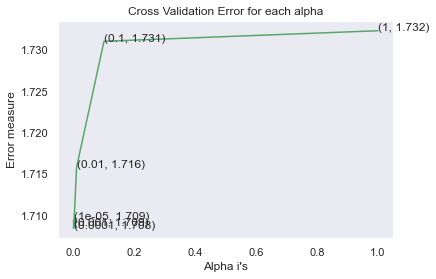

In [64]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [65]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6624445692613405
For values of best alpha =  0.0001 The cross validation log loss is: 1.708434691630544
For values of best alpha =  0.0001 The test log loss is: 1.7110902253456566


In [66]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
val_coverage=val_df[val_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [67]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',val_coverage, 'out of ',val_df.shape[0],":" ,(val_coverage/val_df.shape[0])*100)

1. In test data 78 out of 665 : 11.729323308270677
2. In cross validation data 47 out of  532 : 8.834586466165414


In [68]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [69]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [70]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54254


In [71]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [72]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
val_text_feature_responseCoding  = get_text_responsecoding(val_df)

In [73]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
val_text_feature_responseCoding = (val_text_feature_responseCoding.T/val_text_feature_responseCoding.sum(axis=1)).T

In [74]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
val_text_feature_onehotCoding = text_vectorizer.transform(val_df['TEXT'])
# don't forget to normalize every feature
val_text_feature_onehotCoding = normalize(val_text_feature_onehotCoding, axis=0)

In [75]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [76]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 6324, 4: 3487, 6: 2958, 5: 2810, 8: 2051, 7: 1997, 9: 1869, 10: 1396, 11: 1359, 12: 1341, 15: 941, 13: 876, 14: 830, 16: 770, 18: 676, 17: 648, 24: 624, 20: 593, 19: 584, 22: 491, 21: 427, 30: 407, 28: 400, 23: 374, 25: 373, 27: 363, 48: 323, 26: 322, 43: 311, 32: 286, 36: 278, 29: 260, 35: 256, 33: 255, 34: 250, 31: 249, 40: 244, 39: 230, 42: 222, 38: 210, 37: 182, 41: 180, 44: 178, 45: 175, 46: 162, 51: 159, 54: 158, 52: 153, 56: 150, 60: 143, 57: 143, 66: 142, 50: 141, 49: 140, 47: 140, 53: 128, 58: 124, 72: 122, 55: 120, 64: 113, 63: 113, 61: 107, 65: 106, 59: 105, 68: 102, 78: 100, 70: 96, 62: 95, 69: 92, 67: 92, 75: 91, 86: 89, 80: 86, 76: 84, 77: 83, 74: 83, 73: 81, 88: 79, 71: 78, 96: 74, 81: 74, 92: 73, 105: 71, 91: 70, 79: 70, 85: 69, 84: 68, 83: 66, 93: 65, 100: 62, 82: 59, 106: 58, 95: 58, 90: 58, 120: 57, 98: 57, 99: 55, 87: 55, 114: 54, 102: 54, 94: 53, 89: 53, 117: 52, 110: 51, 108: 49, 107: 49, 104: 47, 97: 47, 103: 46, 113: 45, 124: 44, 119: 44, 116: 44, 11

In [79]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(val_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.287832880778234
For values of alpha =  0.0001 The log loss is: 1.1350016893462676
For values of alpha =  0.001 The log loss is: 1.1342610242998403
For values of alpha =  0.01 The log loss is: 1.2372120638129767
For values of alpha =  0.1 The log loss is: 1.448173254791383
For values of alpha =  1 The log loss is: 1.6448736890293245


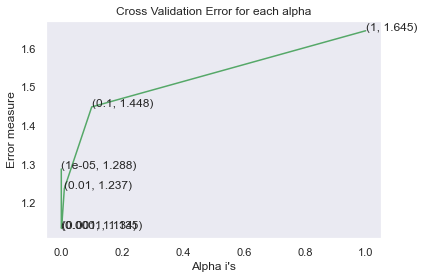

In [80]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [81]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.6550628474749608
For values of best alpha =  0.001 The cross validation log loss is: 1.1342610242998403
For values of best alpha =  0.001 The test log loss is: 1.1074146211707157


In [82]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [84]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(val_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.043 % of word of test data appeared in train data
99.156 % of word of Cross Validation appeared in train data


So that means we analyze and build with 3 columns because all of them are important.

## Data Preparation for Machine Learning Model

In [85]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [86]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [87]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combine all 3 feature together

In [89]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((val_gene_feature_onehotCoding,val_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

val_x_onehotCoding = hstack((cv_gene_var_onehotCoding, val_text_feature_onehotCoding)).tocsr()
val_y = np.array(list(val_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
val_gene_var_responseCoding = np.hstack((val_gene_feature_responseCoding,val_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
val_x_responseCoding = np.hstack((val_gene_var_responseCoding, val_text_feature_responseCoding))


In [90]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", val_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56451)
(number of data points * number of features) in test data =  (665, 56451)
(number of data points * number of features) in cross validation data = (532, 56451)


In [91]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", val_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Naive Bayes

In [92]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(val_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.360405276683119
for alpha = 0.0001
Log Loss : 1.3510667654107769
for alpha = 0.001
Log Loss : 1.3451610227353372
for alpha = 0.1
Log Loss : 1.3139746578612004
for alpha = 1
Log Loss : 1.3041771050850612
for alpha = 10
Log Loss : 1.388635654605497
for alpha = 100
Log Loss : 1.330817102678978
for alpha = 1000
Log Loss : 1.2578535946705385


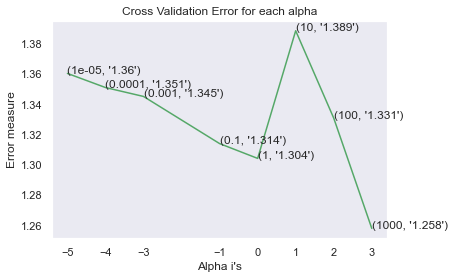

In [93]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [94]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  1000 The train log loss is: 1.0612308219339988
For values of best alpha =  1000 The cross validation log loss is: 1.2578535946705385
For values of best alpha =  1000 The test log loss is: 1.2846624763884493


Log Loss:  1.2578535946705385
Number of missClassified point:  0.43045112781954886
-------------------- Confusion matrix --------------------


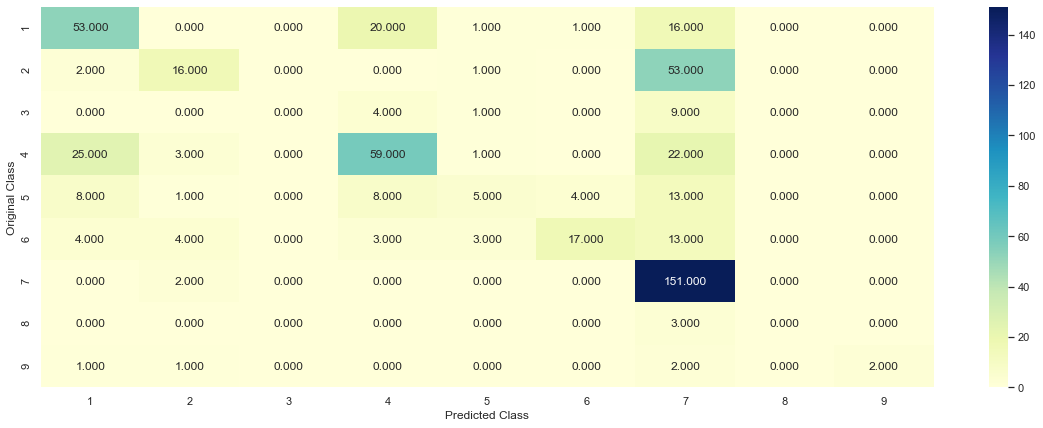

-------------------- Precision matrix (Columm Sum=1) --------------------


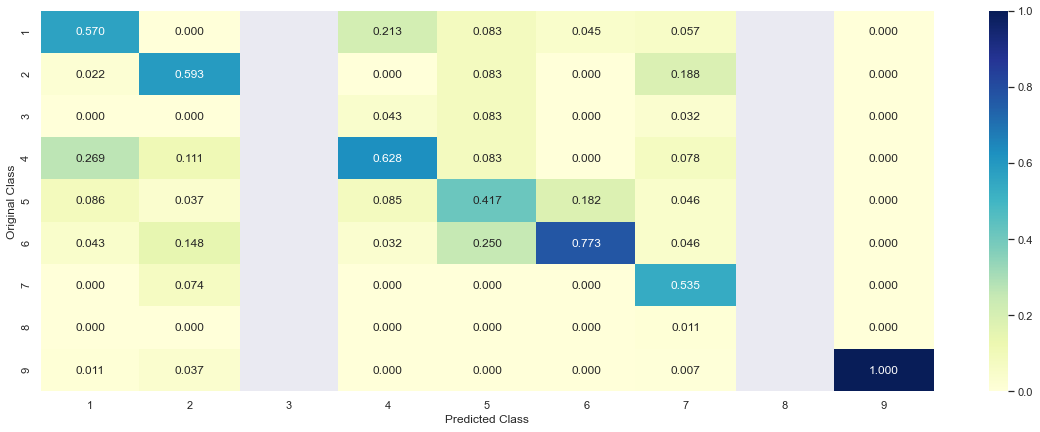

-------------------- Recall matrix (Row sum=1) --------------------


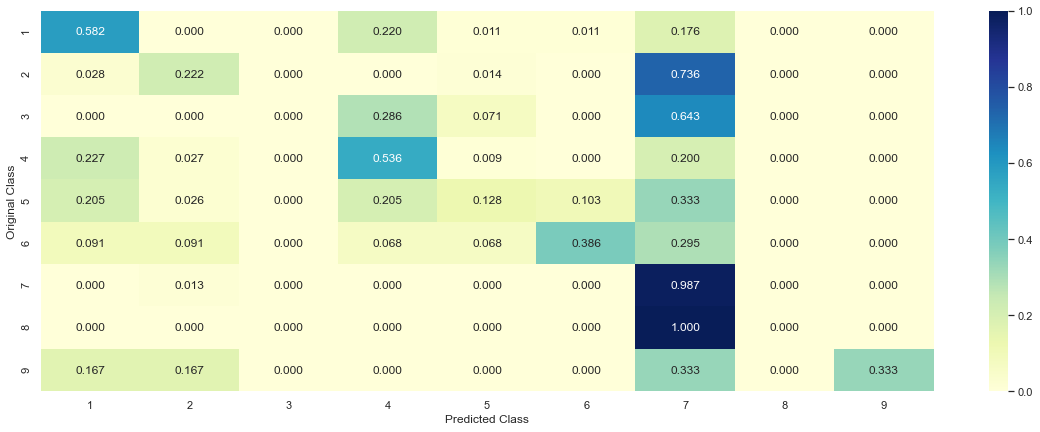

In [95]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
# to avoid rounding error while multiplying probabirlies we use log-probability estimates
print("Log Loss: ", log_loss(val_y, sig_clf_probs))
print("Number of missClassified point: ", np.count_nonzero((sig_clf.predict(val_x_onehotCoding)-val_y))/val_y.shape[0])
plot_confusion_matrix(val_y, sig_clf.predict(val_x_onehotCoding.toarray()))

In [96]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2619 0.047  0.0183 0.5003 0.0277 0.0302 0.1068 0.0054 0.0022]]
Actual Class : 4
--------------------------------------------------
11 Text feature [function] present in test data point [True]
12 Text feature [protein] present in test data point [True]
16 Text feature [mammalian] present in test data point [True]
17 Text feature [proteins] present in test data point [True]
18 Text feature [activity] present in test data point [True]
25 Text feature [functional] present in test data point [True]
26 Text feature [suppressor] present in test data point [True]
27 Text feature [determined] present in test data point [True]
28 Text feature [results] present in test data point [True]
29 Text feature [retained] present in test data point [True]
30 Text feature [determine] present in test data point [True]
31 Text feature [transfected] present in test data point [True]
32 Text feature [type] present in test data point [True]
33 Text feature 

In [97]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0774 0.194  0.0174 0.1633 0.0406 0.0399 0.4551 0.0081 0.0042]]
Actual Class : 4
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
17 Text feature [presence] present in test data point [True]
18 Text feature [downstream] present in test data point [True]
19 Text feature [inhibitor] present in test data point [True]
20 Text feature [activating] present in test data point [True]
22 Text feature [previously] present in test data point [True]
23 Text feature [independent] present in test data point [True]
24 Text feature [recently] present in test data point [True]
25 Text feature [well] present in test data point [True]
27 Text feature [also] present in test data point [True]
29 Text feature [shown] present in test data point [True]
30 Text feature [showed] present in test data point [True]
31 Text feature [compared] present in test data point [True]
32 Text feature [however] 

## K - Nearest Neighbour Classification

In [98]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_responseCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(val_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.098506370790425
for alpha = 11
Log Loss : 1.1027384166447955
for alpha = 15
Log Loss : 1.0932926174442554
for alpha = 21
Log Loss : 1.0846840946795733
for alpha = 31
Log Loss : 1.0681174540452565
for alpha = 41
Log Loss : 1.0738485303705607
for alpha = 51
Log Loss : 1.090954122397171
for alpha = 99
Log Loss : 1.0973899677517998


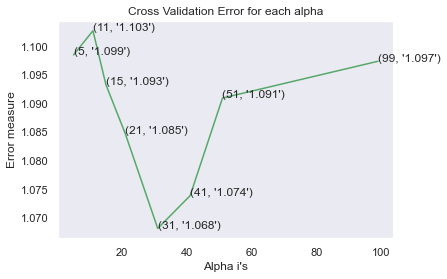

In [99]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [100]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  31 The train log loss is: 0.788270024434283
For values of best alpha =  31 The cross validation log loss is: 1.0681174540452565
For values of best alpha =  31 The test log loss is: 1.0609883711734829


Log loss : 1.0681174540452565
Number of mis-classified points : 0.40225563909774437
-------------------- Confusion matrix --------------------


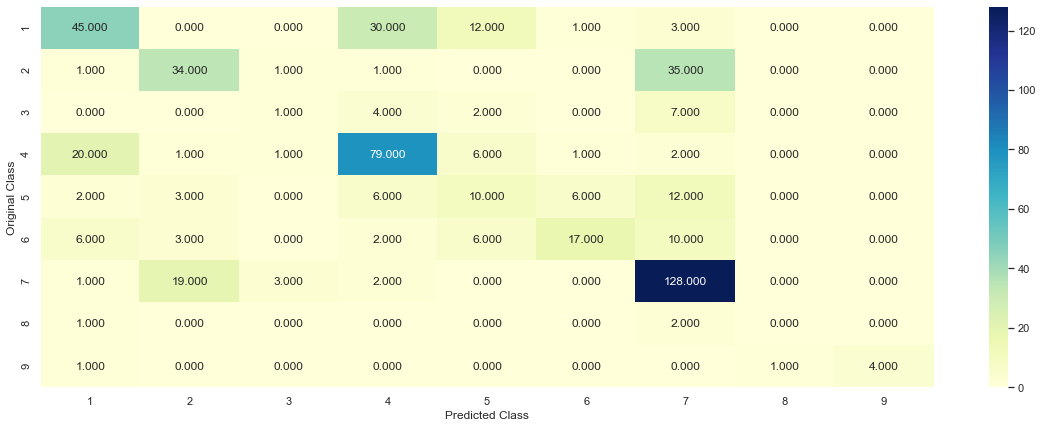

-------------------- Precision matrix (Columm Sum=1) --------------------


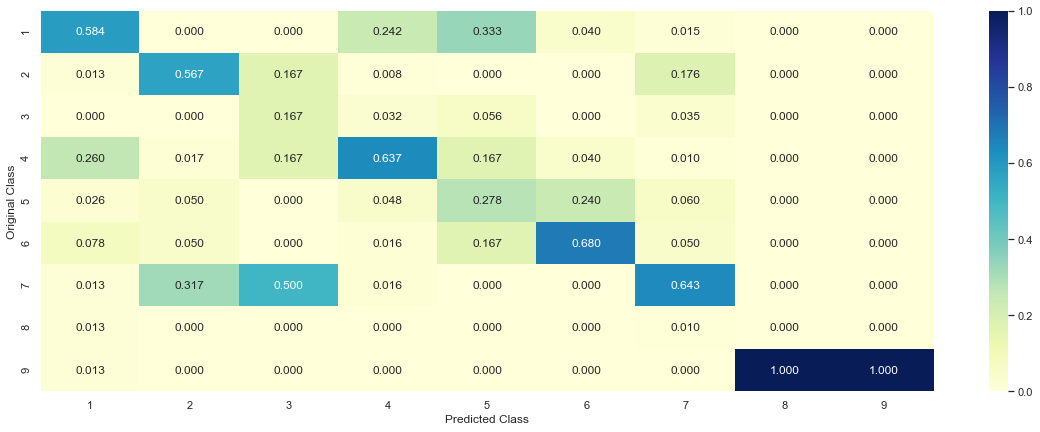

-------------------- Recall matrix (Row sum=1) --------------------


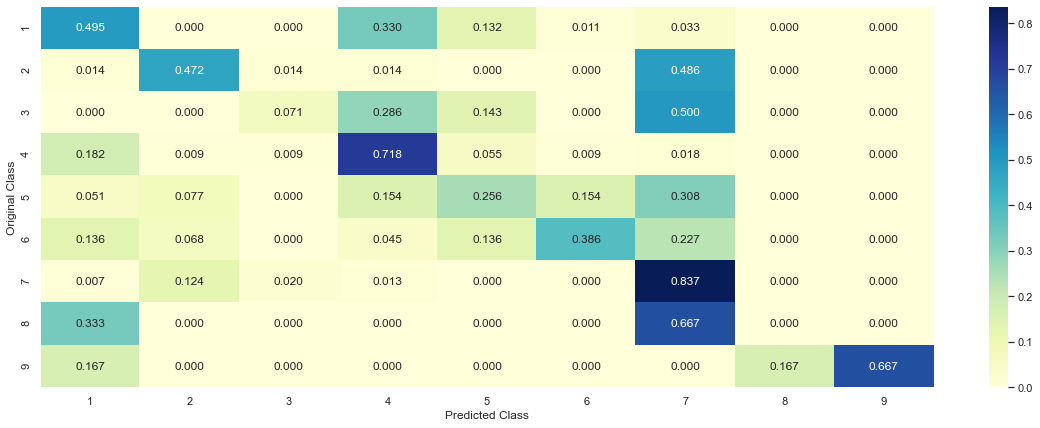

In [101]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, val_x_responseCoding, val_y, clf)

In [102]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))


Predicted Class : 7
Actual Class : 4
The  31  nearest neighbours of the test points belongs to classes [7 7 2 5 2 2 7 7 6 4 7 7 7 7 3 7 7 2 2 1 7 7 7 7 7 2 2 2 4 7 2]
Fequency of nearest points : Counter({7: 16, 2: 9, 4: 2, 5: 1, 6: 1, 3: 1, 1: 1})


In [103]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  31  nearest neighbours of the test points belongs to classes [3 3 1 4 4 1 4 4 1 1 4 1 4 1 1 4 4 4 1 1 1 4 4 2 1 1 1 4 1 1 4]
Fequency of nearest points : Counter({1: 15, 4: 13, 3: 2, 2: 1})


## Logistic Regression

In [104]:
# Balancing all classes
alpha = [10**x for x in range(-6,3)]
cv_log_error_array=[]
for i in alpha:
    print("for alpha=",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(val_y, sig_clf_probs))

for alpha= 1e-06
The log loss is: 1.292377382295379
for alpha= 1e-05
The log loss is: 1.2787418557501105
for alpha= 0.0001
The log loss is: 1.0828520279014924
for alpha= 0.001
The log loss is: 1.0749860048845015
for alpha= 0.01
The log loss is: 1.1487035672455952
for alpha= 0.1
The log loss is: 1.435627337010765
for alpha= 1
The log loss is: 1.6471734515169807
for alpha= 10
The log loss is: 1.6749474069393113
for alpha= 100
The log loss is: 1.6779337919291681


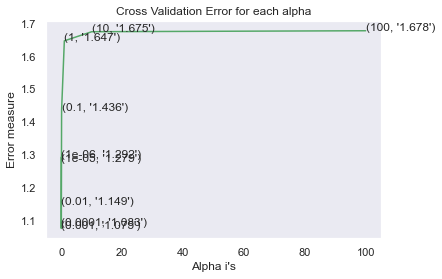

In [105]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [106]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.5256169401454319
For values of best alpha =  0.001 The cross validation log loss is: 1.0749860048845015
For values of best alpha =  0.001 The test log loss is: 1.0378689455725645


Log loss : 1.0749860048845015
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


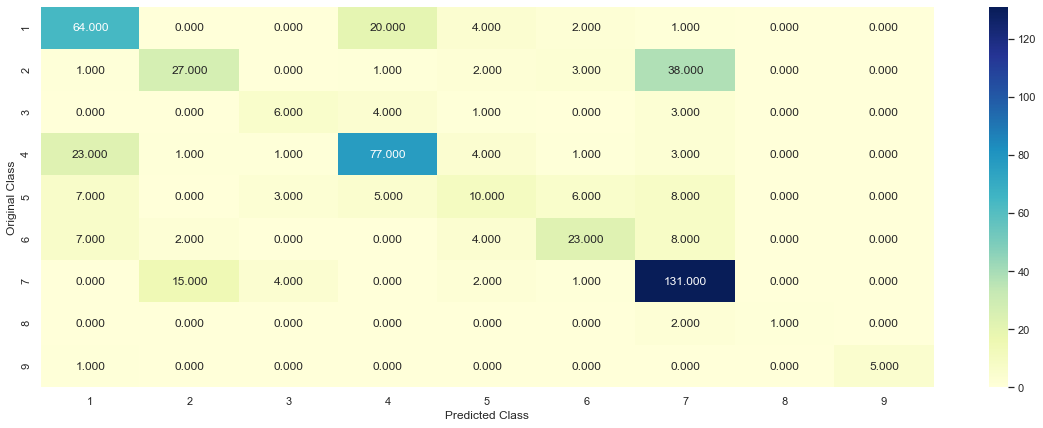

-------------------- Precision matrix (Columm Sum=1) --------------------


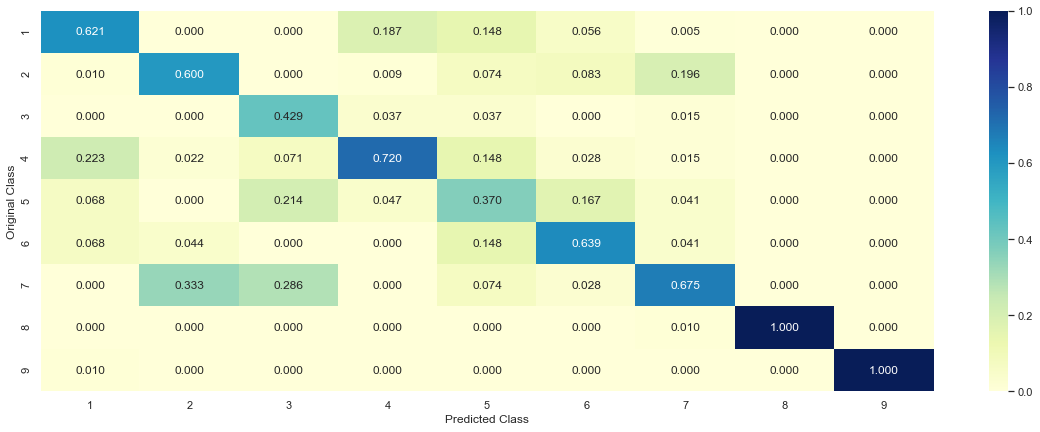

-------------------- Recall matrix (Row sum=1) --------------------


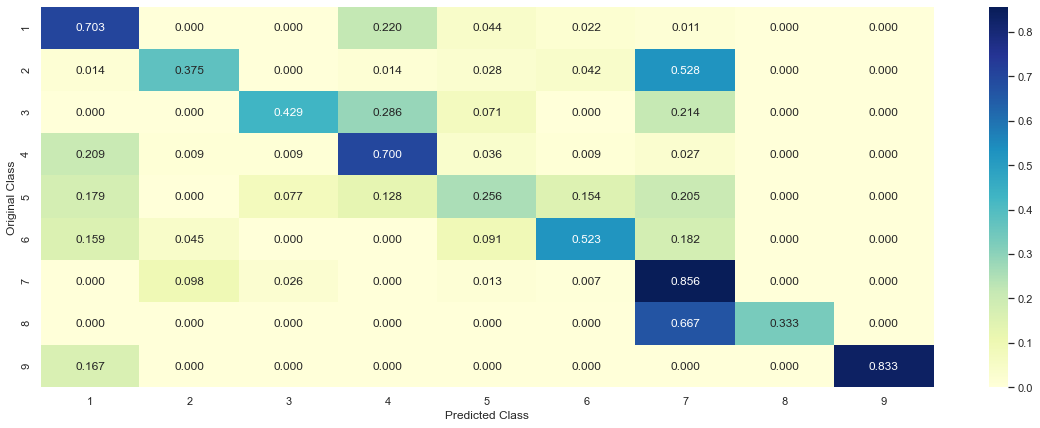

In [107]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [108]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most important features are present in our query point")
    print("-"*50)
    print("The features that are most important of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))


In [109]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0707 0.2238 0.0108 0.2474 0.0326 0.0282 0.3707 0.0075 0.0083]]
Actual Class : 4
--------------------------------------------------
61 Text feature [cysteine] present in test data point [True]
82 Text feature [activated] present in test data point [True]
172 Text feature [ligand] present in test data point [True]
235 Text feature [activation] present in test data point [True]
253 Text feature [downstream] present in test data point [True]
278 Text feature [mitogenesis] present in test data point [True]
280 Text feature [receptors] present in test data point [True]
349 Text feature [tyrosine] present in test data point [True]
389 Text feature [expressing] present in test data point [True]
Out of the top  500  features  9 are present in query point


In [110]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1066 0.0283 0.3313 0.4879 0.0115 0.0092 0.0183 0.0042 0.0027]]
Actual Class : 4
--------------------------------------------------
79 Text feature [e285v] present in test data point [True]
137 Text feature [suppressor] present in test data point [True]
Out of the top  500  features  2 are present in query point


**Without class balancing**

In [111]:
alpha = [10**x for x in range(-6,1)]
cv_log_error_array=[]
for i in alpha:
    print("for alpha=",i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(val_y, sig_clf_probs))

for alpha= 1e-06
The log loss is: 1.2581456305879868
for alpha= 1e-05
The log loss is: 1.2343635202557623
for alpha= 0.0001
The log loss is: 1.0974507944671508
for alpha= 0.001
The log loss is: 1.0722055608624437
for alpha= 0.01
The log loss is: 1.1664267370475963
for alpha= 0.1
The log loss is: 1.3646382517334028
for alpha= 1
The log loss is: 1.5923194003537187


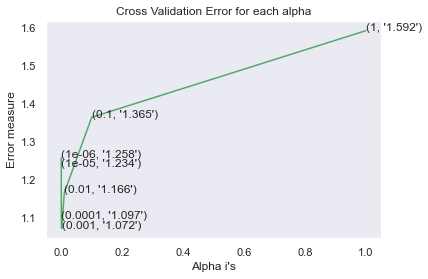

In [112]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [113]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5241172186029148
For values of best alpha =  0.001 The cross validation log loss is: 1.0722055608624437
For values of best alpha =  0.001 The test log loss is: 1.0411056530002145


Log loss : 1.0722055608624437
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


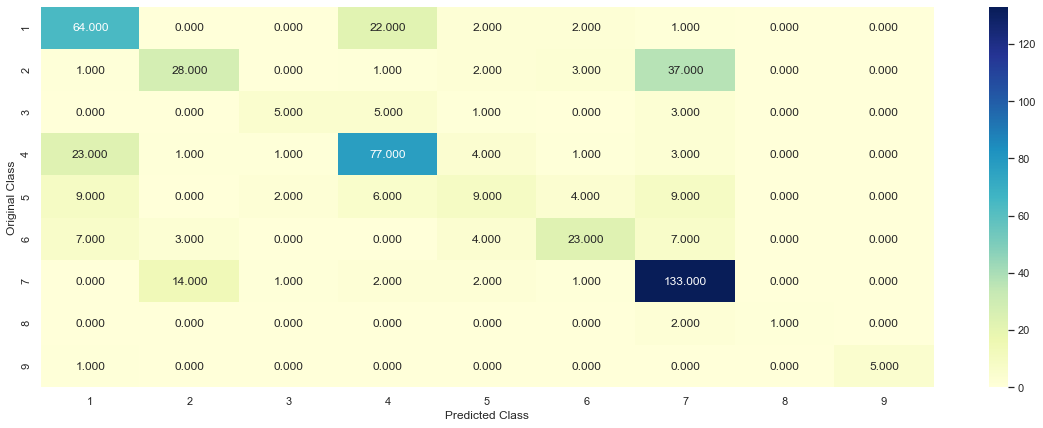

-------------------- Precision matrix (Columm Sum=1) --------------------


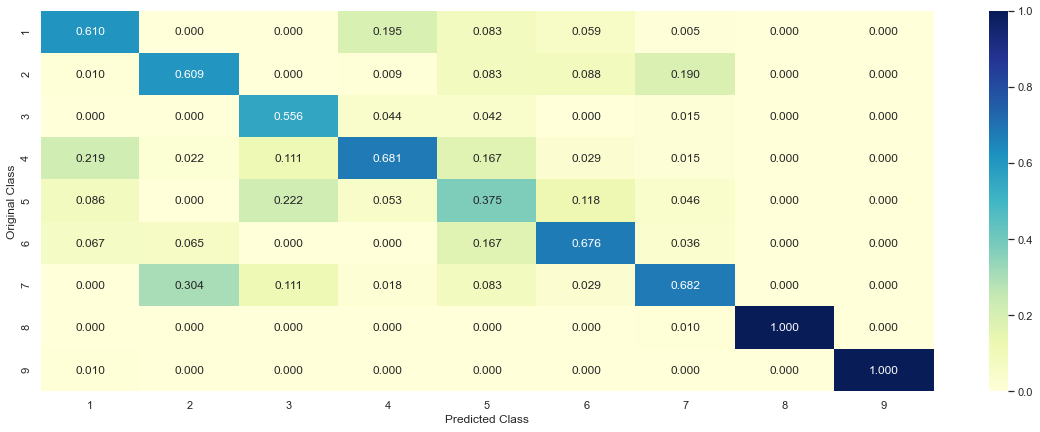

-------------------- Recall matrix (Row sum=1) --------------------


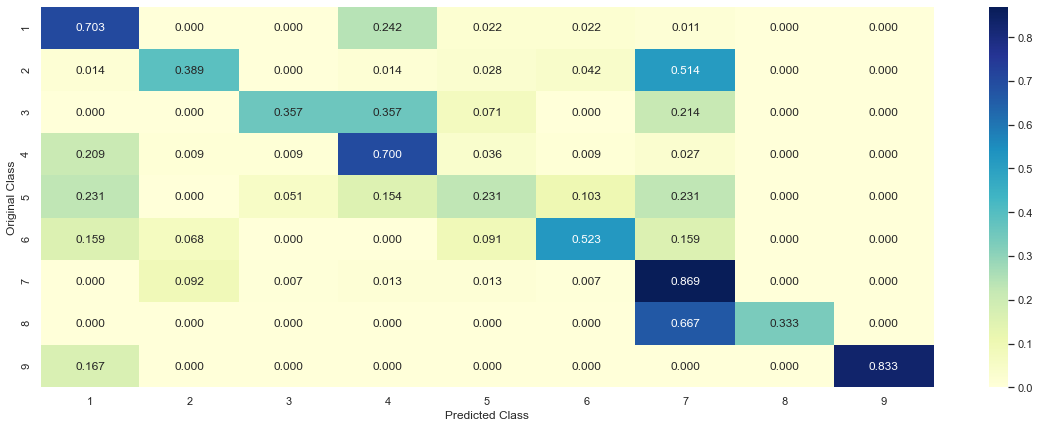

In [114]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [115]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.067  0.2164 0.011  0.2588 0.0314 0.0273 0.376  0.0067 0.0055]]
Actual Class : 4
--------------------------------------------------
119 Text feature [cysteine] present in test data point [True]
184 Text feature [activated] present in test data point [True]
356 Text feature [ligand] present in test data point [True]
368 Text feature [activation] present in test data point [True]
374 Text feature [downstream] present in test data point [True]
400 Text feature [expressing] present in test data point [True]
450 Text feature [receptors] present in test data point [True]
493 Text feature [tyrosine] present in test data point [True]
494 Text feature [mitogenesis] present in test data point [True]
Out of the top  500  features  9 are present in query point


In [116]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1326 0.0315 0.2112 0.5725 0.0129 0.0104 0.0235 0.0037 0.0017]]
Actual Class : 4
--------------------------------------------------
73 Text feature [e285v] present in test data point [True]
203 Text feature [suppressor] present in test data point [True]
Out of the top  500  features  2 are present in query point


## Linear Support Vector Machines

In [117]:
alpha = [10**x for x in range(-5,3)]
cv_log_error_array=[]
for i in alpha:
    print("for C =",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(val_y, sig_clf_probs))

for C = 1e-05
The log loss is: 1.2702703224432073
for C = 0.0001
The log loss is: 1.187350731280785
for C = 0.001
The log loss is: 1.134176554161293
for C = 0.01
The log loss is: 1.1462389069703685
for C = 0.1
The log loss is: 1.3553580222499633
for C = 1
The log loss is: 1.6668163430261065
for C = 10
The log loss is: 1.6784160676208897
for C = 100
The log loss is: 1.6784311902537135


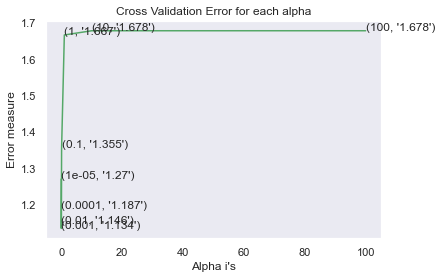

In [118]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [119]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight = 'balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5461136465415443
For values of best alpha =  0.001 The cross validation log loss is: 1.134176554161293
For values of best alpha =  0.001 The test log loss is: 1.099142005117545


Log loss : 1.1167659589108194
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


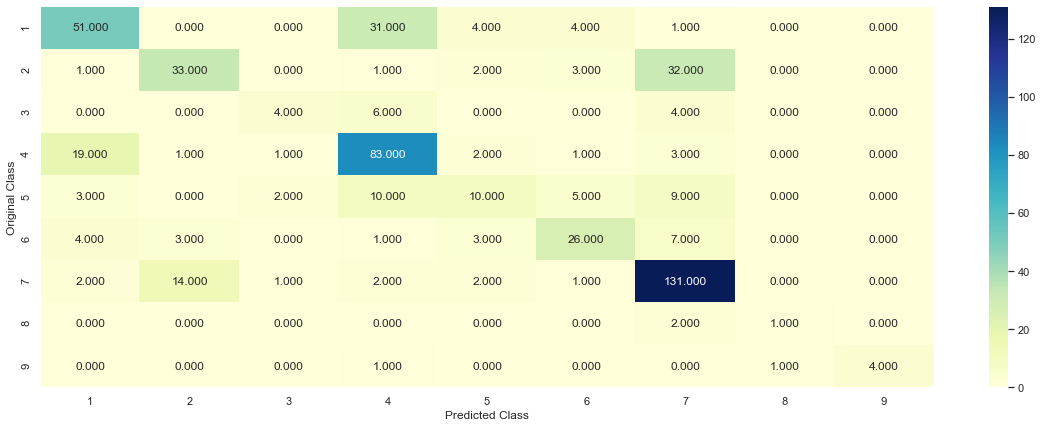

-------------------- Precision matrix (Columm Sum=1) --------------------


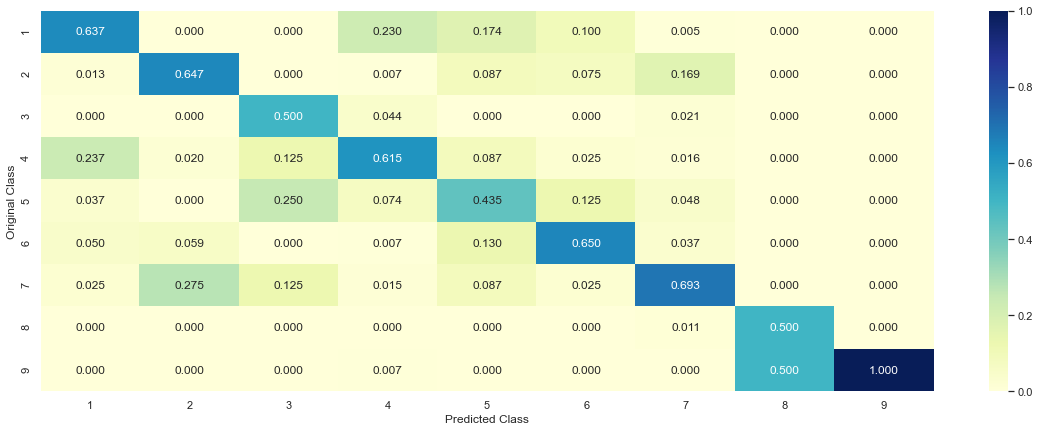

-------------------- Recall matrix (Row sum=1) --------------------


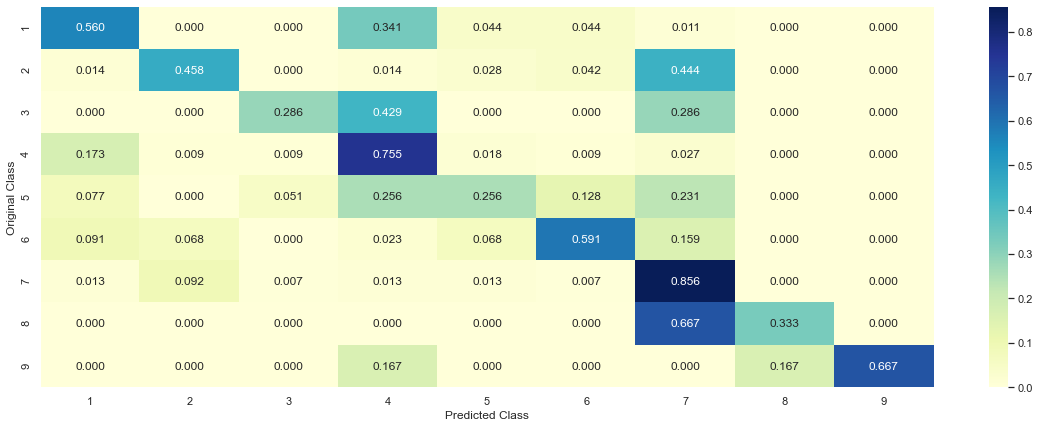

In [120]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [121]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0931 0.1733 0.0154 0.372  0.0426 0.0364 0.2516 0.0064 0.0092]]
Actual Class : 4
--------------------------------------------------
135 Text feature [dab2ip] present in test data point [True]
152 Text feature [70kda] present in test data point [True]
211 Text feature [dab2] present in test data point [True]
315 Text feature [lys] present in test data point [True]
353 Text feature [acetylation] present in test data point [True]
497 Text feature [tagged] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [122]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.0659 0.0743 0.4162 0.2857 0.0417 0.0079 0.0963 0.0062 0.0058]]
Actual Class : 4
--------------------------------------------------
125 Text feature [al35] present in test data point [True]
Out of the top  500  features  1 are present in query point


In [123]:
test_point_index = 50
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.1586 0.0859 0.0098 0.2667 0.3539 0.0052 0.107  0.006  0.0069]]
Actual Class : 5
--------------------------------------------------
236 Text feature [v1833m] present in test data point [True]
460 Text feature [probabilities] present in test data point [True]
Out of the top  500  features  2 are present in query point


**RF with Response Coding**

In [124]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(val_x_responseCoding)
        cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(val_y, sig_clf_probs)) 

for n_estimators = 10 and max depth =  2
Log Loss : 2.115170071035075
for n_estimators = 10 and max depth =  3
Log Loss : 1.7395035845938451
for n_estimators = 10 and max depth =  5
Log Loss : 1.508327963732725
for n_estimators = 10 and max depth =  10
Log Loss : 1.971678627310959
for n_estimators = 50 and max depth =  2
Log Loss : 1.7318951415476176
for n_estimators = 50 and max depth =  3
Log Loss : 1.4581360533382572
for n_estimators = 50 and max depth =  5
Log Loss : 1.3569079258988253
for n_estimators = 50 and max depth =  10
Log Loss : 1.8312186080024542
for n_estimators = 100 and max depth =  2
Log Loss : 1.5766204260561572
for n_estimators = 100 and max depth =  3
Log Loss : 1.498181887576004
for n_estimators = 100 and max depth =  5
Log Loss : 1.3499691757617827
for n_estimators = 100 and max depth =  10
Log Loss : 1.745701430092902
for n_estimators = 200 and max depth =  2
Log Loss : 1.607120198139488
for n_estimators = 200 and max depth =  3
Log Loss : 1.5292941216321396
for

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  100 The train log loss is: 0.06707194140832975
For values of best alpha =  100 The cross validation log loss is: 1.2014256411080937
For values of best alpha =  100 The test log loss is: 1.2534121103091806


In [125]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  100 The train log loss is: 0.065846861867508
For values of best alpha =  100 The cross validation log loss is: 1.3499691757617827
For values of best alpha =  100 The test log loss is: 1.3551407366687256


Log loss : 1.222000185208417
Number of mis-classified points : 0.44548872180451127
-------------------- Confusion matrix --------------------


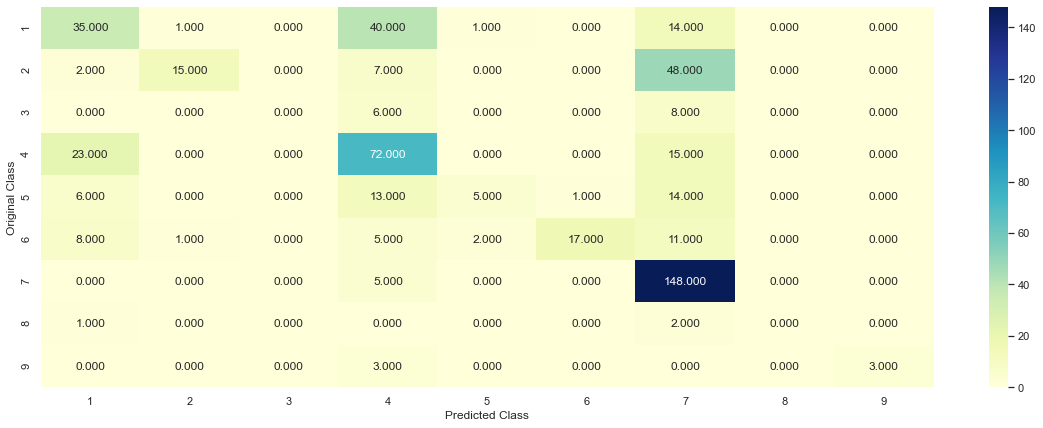

-------------------- Precision matrix (Columm Sum=1) --------------------


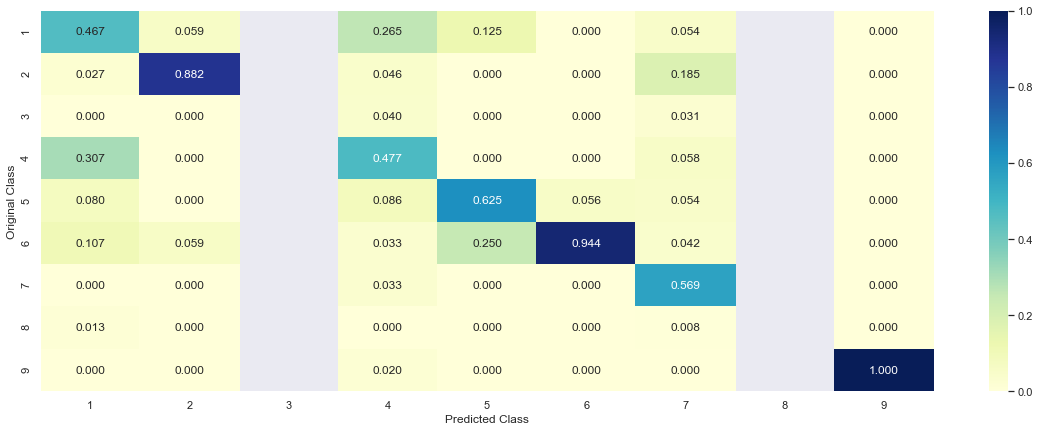

-------------------- Recall matrix (Row sum=1) --------------------


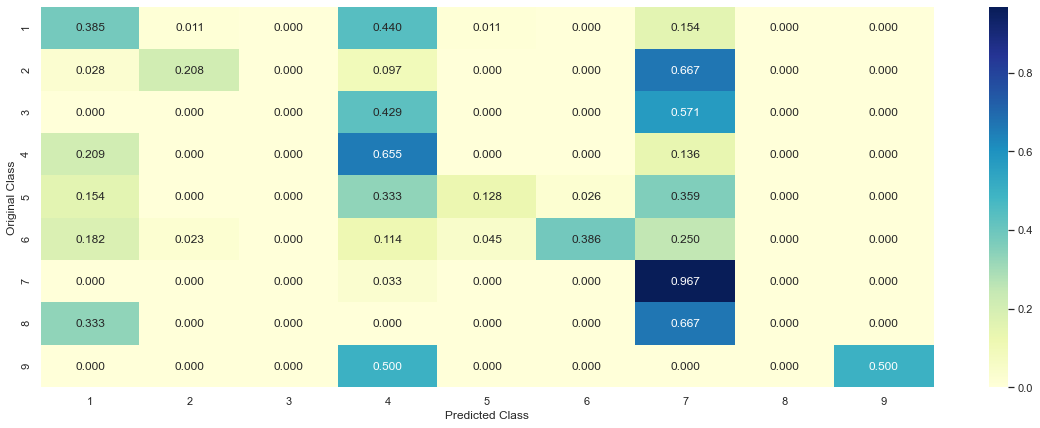

In [126]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [127]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.045  0.2067 0.1549 0.1388 0.0617 0.0659 0.1549 0.1104 0.0619]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [128]:
test_point_index = 100
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.2576 0.0278 0.2187 0.3582 0.031  0.0371 0.0101 0.0339 0.0256]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## Random Forest Classifer

In [129]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
        cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(val_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.222000073560276
for n_estimators = 100 and max depth =  10
Log Loss : 1.1527086448251602
for n_estimators = 200 and max depth =  5
Log Loss : 1.2186166035233241
for n_estimators = 200 and max depth =  10
Log Loss : 1.1409055860272421
for n_estimators = 500 and max depth =  5
Log Loss : 1.209126933377147
for n_estimators = 500 and max depth =  10
Log Loss : 1.137241060239035
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2067534216534854
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1345100670563883
for n_estimators = 2000 and max depth =  5
Log Loss : 1.208096260032002
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1351873785149942


In [130]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  1000 The train log loss is: 0.6869517295687125
For values of best estimator =  1000 The cross validation log loss is: 1.1345100670563883
For values of best estimator =  1000 The test log loss is: 1.1140740232409005


Log loss : 1.1345100670563881
Number of mis-classified points : 0.39285714285714285
-------------------- Confusion matrix --------------------


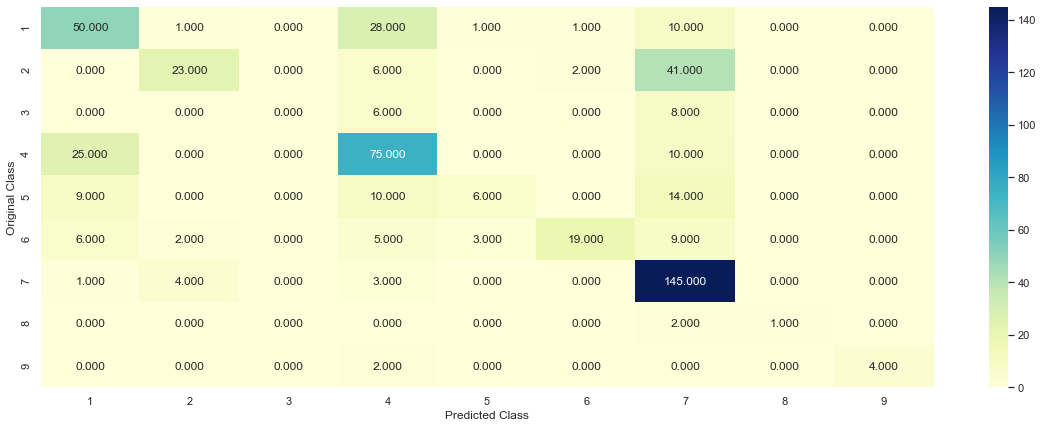

-------------------- Precision matrix (Columm Sum=1) --------------------


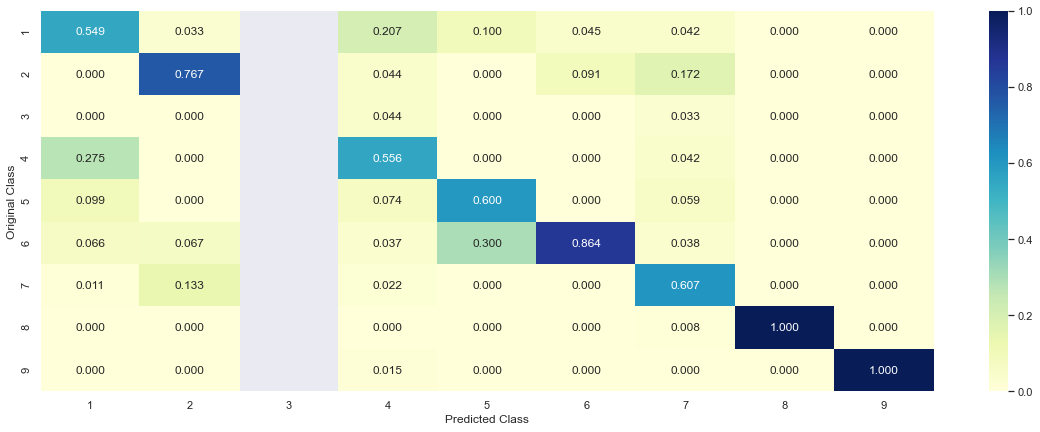

-------------------- Recall matrix (Row sum=1) --------------------


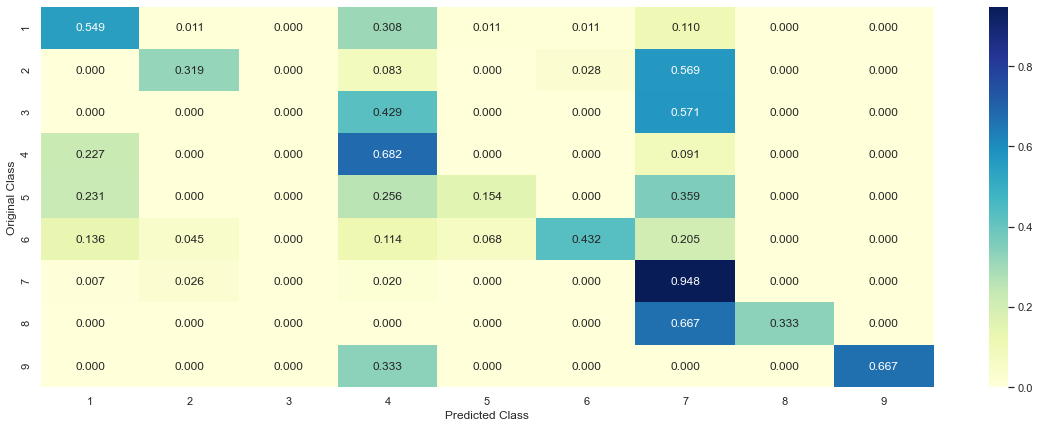

In [131]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, cv_y, clf)

In [132]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1672 0.1349 0.0264 0.2047 0.0606 0.0552 0.3354 0.0077 0.0079]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [tyrosine] present in test data point [True]
2 Text feature [activating] present in test data point [True]
3 Text feature [suppressor] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
7 Text feature [function] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
9 Text feature [activation] present in test data point [True]
10 Text feature [activated] present in test data point [True]
13 Text feature [inhibitor] present in test data point [True]
15 Text feature [kinases] present in test data point [True]
18 Text feature [signaling] present in test data point [True]
20 Text feature [cells] present in test data point [True]
22 Text feature [

## Stacking Model

In [133]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(val_y, sig_clf1.predict_proba(val_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(val_y, sig_clf2.predict_proba(val_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(val_y, sig_clf3.predict_proba(val_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(val_y, sclf.predict_proba(val_x_onehotCoding))))
    log_error =log_loss(val_y, sclf.predict_proba(val_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error


Logistic Regression :  Log Loss: 1.08
Support vector machines : Log Loss: 1.67
Naive Bayes : Log Loss: 1.35
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.728
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.347
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.198
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.461
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.819


Log loss (train) on the stacking classifier : 0.49661727290252616
Log loss (CV) on the stacking classifier : 1.19753857459486
Log loss (test) on the stacking classifier : 1.1292828300677116
Number of missclassified point : 0.3383458646616541
-------------------- Confusion matrix --------------------


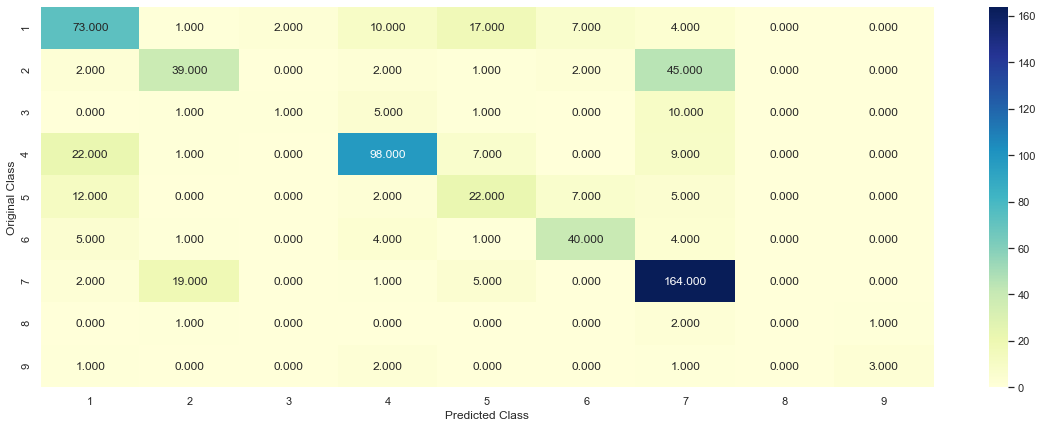

-------------------- Precision matrix (Columm Sum=1) --------------------


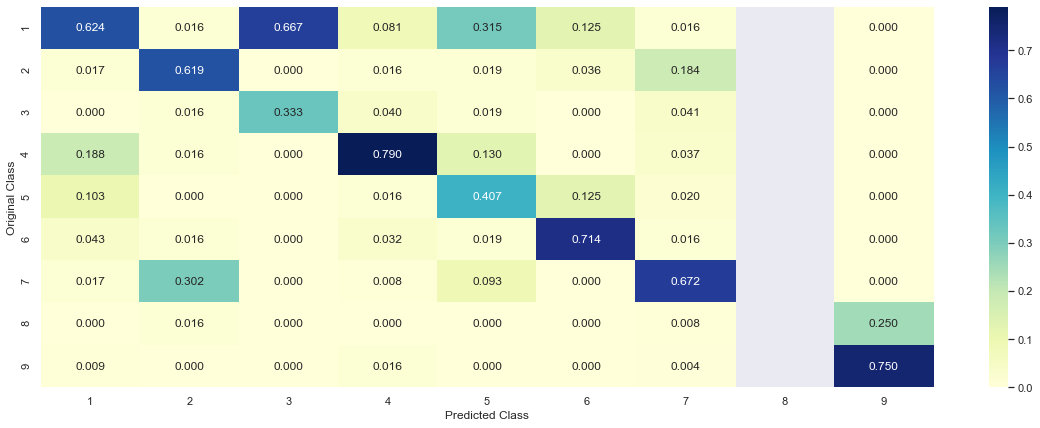

-------------------- Recall matrix (Row sum=1) --------------------


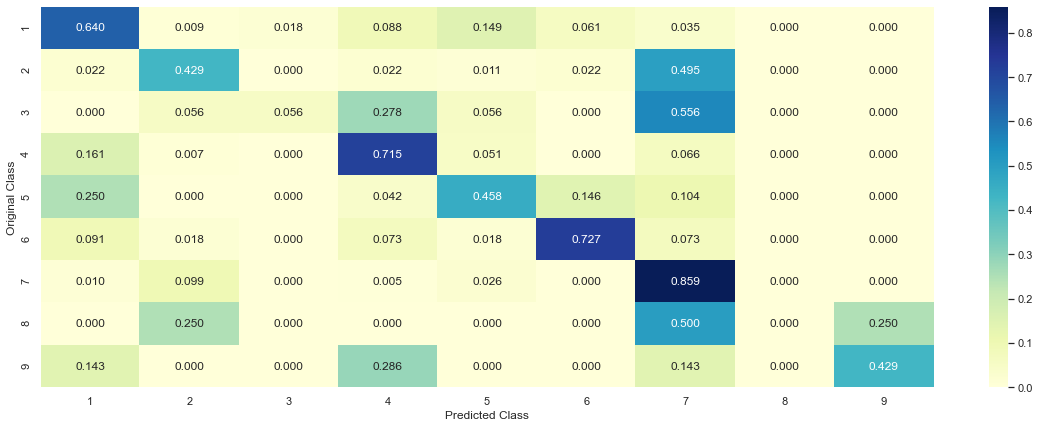

In [134]:
#Testing with the best hyper param
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(val_y, sclf.predict_proba(val_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum Voting Classifier

Log loss (train) on the  Votingclassifier : 0.8624146423420969
Log loss (cv) on the  Votingclassifier : 1.2134917186549488
Log loss (test) on the  Votingclassifier : 1.1881078190684597
Number of missclassified point : 0.34887218045112783
-------------------- Confusion matrix --------------------


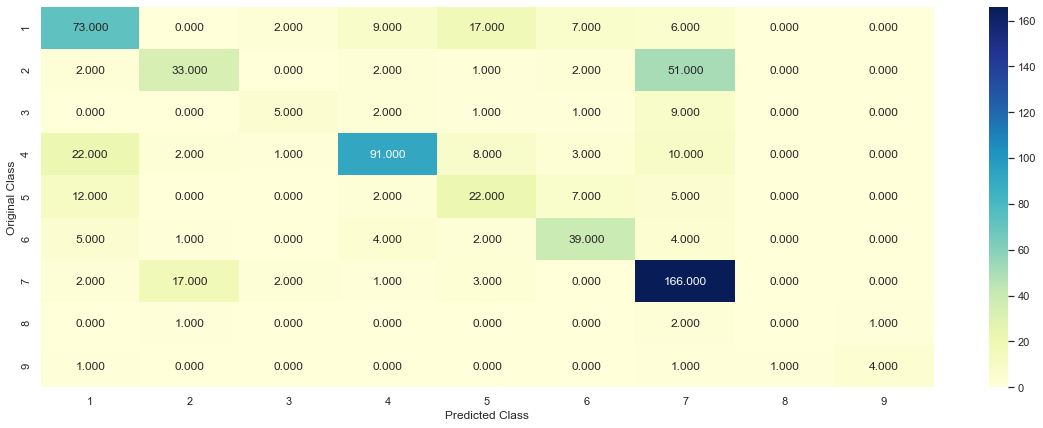

-------------------- Precision matrix (Columm Sum=1) --------------------


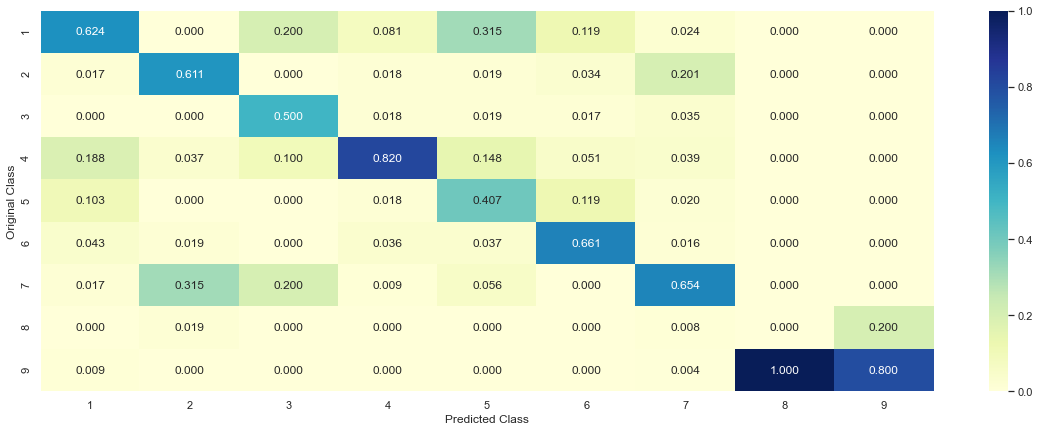

-------------------- Recall matrix (Row sum=1) --------------------


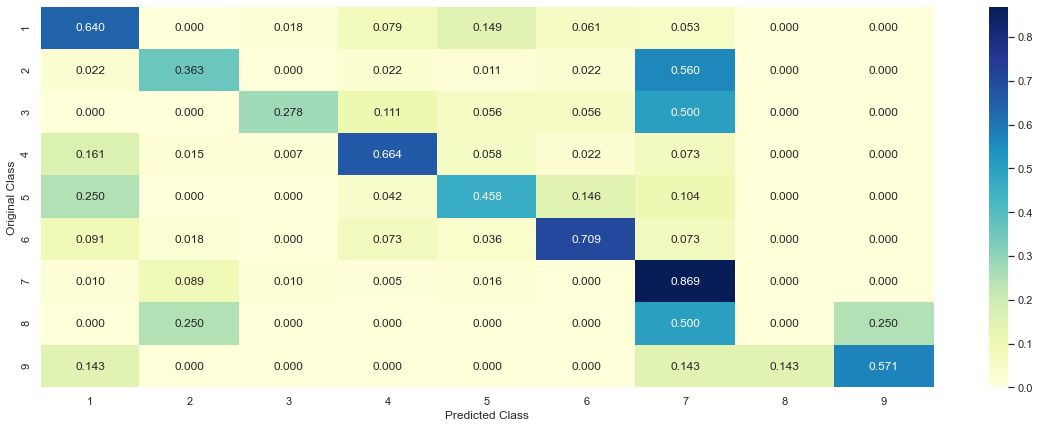

In [135]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators = [('lr', sig_clf1),('svc', sig_clf2),('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the  Votingclassifier :",log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (cv) on the  Votingclassifier :",log_loss(val_y, vclf.predict_proba(val_x_onehotCoding)))
print("Log loss (test) on the  Votingclassifier :",log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))

print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))